# Project: Analyzing Relationship Between Demographic Factors and SAT Scores in NYC High Schools

Every year, New York City makes their data on NYC High Schools demographic information and SAT Scores available online. 

There have long been debates on the fairness of the SAT, with many pundits claiming that the test is unfair for certain demographic groups. 

In this project, I will use the open-source data provided by the NYC government to analyze the relationship between SAT Scores and Demographic Factors in NYC Public High Schools.

In order to do this analysis, I will first download the various datasets, clean them to make sure they are no errors, combine them into one dataset in order to find correlations, and then create some plots to discover patterns in the correlations.

## **Reading in the data**

The first step is to read in the various datasets containing the SAT Score data as well as the NYC demographic data. There are 6 different datasets; AP Test Results, Class Size info, Demographic Info, Graduation Outcome info, Directory of all High Schools in NYC, and finally SAT results.

I will read each file into a pandas dataframe and then store all of the dataframes in a dictionary. This is a convenient way to store them and will allow for easier reference later on.

In [1]:
import pandas as pd
import numpy as np
import re
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}
for f in data_files:
    d = pd.read_csv('schools/{0}'.format(f))
    data[f.replace('.csv', '')] = d

## **Reading in the surveys**

On top of the previous datasets, there are two surveys that provide more information. These surveys are taken by all parents, teachers and students. The results provide insight into a school's learning enviroment. The survey questions assess the school community's opinions on academic expectations, communication, engagement and safety and respect. 

There are two surveys represented, one contains data from all schools and one contains data from NYC district 75 schools. Further research revealed that district 75 schools provides specialized instruction for students with special needs. 

I will first read in the two datasets and then combine them into a single dataframe in order to do further analysis. 

In [2]:
all_survey = pd.read_csv('schools/survey_all.txt', delimiter='\t', encoding='windows-1252')
d75_survey = pd.read_csv('schools/survey_d75.txt', delimiter='\t', encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

Now that I've combined the surveys, I'll display the first five rows to get a preview of the data and see if there's anything that needs to be cleaned.

In [3]:
survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Cleaning the Surveys**

Based on the previous results, there are two immediate things that jump out that need to be fixed. The first thing is that there are over 2000 columns in the dataset, far more than neccessary. The first step is to filter the columns by only choosing the ones neccessary for analysis. To choose the columns, I consulted the data dictionary and chose the columns which reveal how the community feels about school safety, academic performance and communication. 

The second issue is the dbn column, the dbn column represents the unique school ID of each NYC High School. The other datasets also have the column but in all uppercase (DBN). I will convert the survey dbn column to uppercase to ensure consistency when I later combine the datasets.

In [4]:
survey['DBN'] = survey['dbn']

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]

survey = survey.loc[:, survey_fields]
data['survey'] = survey

## **Adding DBN columns**

When I explored the datasets, I noticed that the class_size and hs_directory sets did not have a DBN column.

In [5]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


In [6]:
data['hs_directory'].head()

,dbn,school_name,borough,building_code,phone_number,fax_number,grade_span_min,grade_span_max,expgrade_span_min,expgrade_span_max,...,priority08,priority09,priority10,Location 1,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,27Q260,Frederick Douglass Academy VI High School,Queens,Q465,718-471-2154,718-471-2890,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"8 21 Bay 25 Street\nFar Rockaway, NY 11691\n(4...",14.0,31.0,100802.0,4300730.0,4.157360e+09,Far Rockaway-Bayswater ...
1,21K559,Life Academy High School for Film and Music,Brooklyn,K400,718-333-7750,718-333-7775,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"2630 Benson Avenue\nBrooklyn, NY 11214\n(40.59...",13.0,47.0,306.0,3186454.0,3.068830e+09,Gravesend ...
2,16K393,Frederick Douglass Academy IV Secondary School,Brooklyn,K026,718-574-2820,718-574-2821,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"1014 Lafayette Avenue\nBrooklyn, NY 11221\n(40...",3.0,36.0,291.0,3393805.0,3.016160e+09,Stuyvesant Heights ...
3,08X305,Pablo Neruda Academy,Bronx,X450,718-824-1682,718-824-1663,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"1980 Lafayette Avenue\nBronx, NY 10473\n(40.82...",9.0,18.0,16.0,2022205.0,2.036040e+09,Soundview-Castle Hill-Clason Point-Harding Par...
4,03M485,Fiorello H. LaGuardia High School of Music & A...,Manhattan,M485,212-496-0700,212-724-5748,9.0,12,NaN,NaN,...,NaN,NaN,NaN,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",7.0,6.0,151.0,1030341.0,1.011560e+09,Lincoln Square ...


It appears that hs_directory has a dbn column in lowercase, so I just need to change that column to uppercase. 

In [7]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

The class_size column doesn't appear to have the column at all, meaning I have to create it myself. To figure out what the column contains I compared it to the sat_results dataframe which does have a DBN column.

In [8]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


Comparing this with the class_size dataset it clearly shows that the DBN column is a combination of the CSD, Borough and School code columns. The DBN column in the sat_results dataframe also always starts with 0 and is at least two digits, so I need to add that in the new DBN column as well. I do this by creating a function named pad_csd and then apply it to the columns in class_size.

In [9]:
def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation

data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(pad_csd)
data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']

In [10]:
data['class_size'].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01,01M015


## **Combining SAT Scores**

When I displayed the sat_results dataframe earlier, I noticed that there was no column with an aggregated total score combining the three scores from each section.

So I am going to create a new column called sat_score containing the combined score. To do so I first need to change the columns to a numeric data type and then I can add the three scores together.

In [11]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

Here is what the new dataframe looks like.

In [12]:
data['sat_results'].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0


## **Condensing Datasets**

When I explored the class size dataframe above, I noticed that the DBN column was not unique and that multiple rows shared the same DBN. The goal is to condense the datasets so that the DBN column is a unique value for every row. 

The first step in condensing the data is to filter the dataframe so that only Grades 9-12 and the GEN ED Program type are left. Currently the dataframe contains information from Grades K-12 and multiple program types that aren't neccesary for the analysis.

In [13]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

In [14]:
class_size.head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,padded_csd,DBN
225,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 9,-,63.0,3.0,21.0,19.0,25.0,STARS,NaN,01,01M292
226,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 10,-,79.0,3.0,26.3,24.0,31.0,STARS,NaN,01,01M292
227,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 11,-,38.0,2.0,19.0,16.0,22.0,STARS,NaN,01,01M292
228,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,ENGLISH,English 12,-,69.0,3.0,23.0,13.0,30.0,STARS,NaN,01,01M292
229,1,M,M292,Henry Street School for International Studies,09-12,GEN ED,MATH,Integrated Algebra,-,53.0,3.0,17.7,16.0,21.0,STARS,NaN,01,01M292


From the above display it is clear that the DBN column is still not fully unique. This is because the dataframe is still segmented by the Core Subject and Core Course Columns. Class size data segmented by subject is not important to the analysis, instead I would like to calculate the average class size for each unique DBN which represents each unique High School.

The solution is to take the average value for each column associated with each DBN. By using the groupby() and agg() methods.

In [15]:
class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size

In [16]:
class_size.head()

,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


Now we have a unique DBN value for each row.

The next step is to condense the Demographics dataset.

In [17]:
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
0,01M015,P.S. 015 ROBERTO CLEMENTE,20052006,89.4,NaN,281,15,36,40,33,...,74,26.3,189,67.3,5,1.8,158.0,56.2,123.0,43.8
1,01M015,P.S. 015 ROBERTO CLEMENTE,20062007,89.4,NaN,243,15,29,39,38,...,68,28.0,153,63.0,4,1.6,140.0,57.6,103.0,42.4
2,01M015,P.S. 015 ROBERTO CLEMENTE,20072008,89.4,NaN,261,18,43,39,36,...,77,29.5,157,60.2,7,2.7,143.0,54.8,118.0,45.2
3,01M015,P.S. 015 ROBERTO CLEMENTE,20082009,89.4,NaN,252,17,37,44,32,...,75,29.8,149,59.1,7,2.8,149.0,59.1,103.0,40.9
4,01M015,P.S. 015 ROBERTO CLEMENTE,20092010,,96.5,208,16,40,28,32,...,67,32.2,118,56.7,6,2.9,124.0,59.6,84.0,40.4


As we can see above, the Demographics dataset has the same issue as the class size dataset had before, the DBN values are not unique for each column.

Further investigation shows that the reason for this issue is because the demographic data is segmented by each schoolyear. To solve this problem I will only choose the rows where schoolyear is equl to 20112012. This is the most recent year of data and will solve the issue.

In [18]:
data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]
data['demographics'].head()

,DBN,Name,schoolyear,fl_percent,frl_percent,total_enrollment,prek,k,grade1,grade2,...,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per
6,01M015,P.S. 015 ROBERTO CLEMENTE,20112012,NaN,89.4,189,13,31,35,28,...,63,33.3,109,57.7,4,2.1,97.0,51.3,92.0,48.7
13,01M019,P.S. 019 ASHER LEVY,20112012,NaN,61.5,328,32,46,52,54,...,81,24.7,158,48.2,28,8.5,147.0,44.8,181.0,55.2
20,01M020,PS 020 ANNA SILVER,20112012,NaN,92.5,626,52,102,121,87,...,55,8.8,357,57.0,16,2.6,330.0,52.7,296.0,47.3
27,01M034,PS 034 FRANKLIN D ROOSEVELT,20112012,NaN,99.7,401,14,34,38,36,...,90,22.4,275,68.6,8,2.0,204.0,50.9,197.0,49.1
35,01M063,PS 063 WILLIAM MCKINLEY,20112012,NaN,78.9,176,18,20,30,21,...,41,23.3,110,62.5,15,8.5,97.0,55.1,79.0,44.9


Problem Solved!

The final dataset to condense is the graduation dataset. 

In [19]:
data['graduation']

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
0,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2003,5,s,NaN,s,NaN,NaN,...,s,NaN,NaN,s,NaN,NaN,s,NaN,s,NaN
1,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2004,55,37,67.3,17,30.9,45.9,...,17,30.9,45.9,20,36.4,54.1,15,27.3,3,5.5
2,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2005,64,43,67.2,27,42.2,62.8,...,27,42.2,62.8,16,25.0,37.2,9,14.1,9,14.1
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
4,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006 Aug,78,44,56.4,37,47.4,84.1,...,37,47.4,84.1,7,9.0,15.9,15,19.2,11,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25091,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2003,65,1,1.5,0,0.0,0.0,...,0,0.0,0.0,1,1.5,100.0,44.0,67.7,20.0,30.8
25092,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2004,64,2,3.1,0,0.0,0.0,...,0,0.0,0.0,2,3.1,100.0,38.0,59.4,22.0,34.4
25093,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2005,79,3,3.8,1,1.3,33.3,...,1,1.3,33.3,2,2.5,66.7,46.0,58.2,28.0,35.4
25094,Male,32K564,BUSHWICK COMMUNITY HIGH SCHOOL,2006,57,4,7.0,2,3.5,50.0,...,2,3.5,50.0,2,3.5,50.0,34.0,59.6,17.0,29.8


Investigation shows that the Demographic and Cohort columns are what prevent DBN from being unique in the dataset. Cohort refers to the year the data represents and demographic shows what demographic group the data represents. To segment the data, I will pick data from the most recent cohort which is 2006 and I will choose rows where the Demographic column is equal to Total Cohort because I want to work with only data from the full cohort.

In [20]:
data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']
data['graduation'].head()

,Demographic,DBN,School Name,Cohort,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,...,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort
3,Total Cohort,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL,2006,78,43,55.1,36,46.2,83.7,...,36,46.2,83.7,7,9.0,16.3,16,20.5,11,14.1
10,Total Cohort,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,2006,124,53,42.7,42,33.9,79.2,...,34,27.4,64.2,11,8.9,20.8,46,37.1,20,16.1
17,Total Cohort,01M450,EAST SIDE COMMUNITY SCHOOL,2006,90,70,77.8,67,74.4,95.7,...,67,74.4,95.7,3,3.3,4.3,15,16.7,5,5.6
24,Total Cohort,01M509,MARTA VALLE HIGH SCHOOL,2006,84,47,56.0,40,47.6,85.1,...,23,27.4,48.9,7,8.3,14.9,25,29.8,5,6.0
31,Total Cohort,01M515,LOWER EAST SIDE PREPARATORY HIGH SCHO,2006,193,105,54.4,91,47.2,86.7,...,22,11.4,21.0,14,7.3,13.3,53,27.5,35,18.1


## **Combining the datasets**

Now that all of the datasets have been cleaned I am ready to combine them. I will start by combining the sat_results dataframe to the ap_2010 and graduation datasets through left joins because both of those datasets have many missing DBN values and I don't want to lose out on any rows from sat_results because it is the subject that I'm analyzing specifically for this project.

In [40]:
combined = data['sat_results']

combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

## **Finding correlations**

Now that I have combined the datasets into one file, I want to investigate correlations between categories and the SAT Score to see if anything jumps out. I use Pearson's correlation coefficient, also known as the r value. The r value falls between -1 and 1, the closer to 1 the r value is, the stronger the correlation. An r value of 0 means no correlation occurs. 

In [55]:
correlations = combined.corr()
correlations = correlations['sat_score']
correlations[0:20]

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
Total Grads - % of cohort               0.584234
Total Regents - % of cohort             0.667603
Total Regents - % of grads              0.494732
Advanced Regents - % of cohort          0.771566
Advanced Regents - % of grads           0.739927
Regents w/o Advanced - % of cohort     -0.138188
Regents w/o Advanced - % of grads      -0.456213
Local - % of cohort                    -0.467951
Local - % of grads                     -0.494732
Still Enrolled - % of cohort           -0.491914
Dropped Out - % of cohort              -0.458537
CSD                                     0.042948
Name: sat_score, dty

In [50]:
correlations[-20:]

aca_s_11             0.339435
saf_tot_11           0.318753
com_tot_11           0.077310
eng_tot_11           0.100102
aca_tot_11           0.190966
grade_span_min      -0.021315
grade_span_max            NaN
expgrade_span_min         NaN
expgrade_span_max         NaN
postcode            -0.063977
total_students       0.407827
number_programs      0.117012
priority08                NaN
priority09                NaN
priority10                NaN
Community Board     -0.060919
Council District    -0.076151
Census Tract         0.048737
BIN                  0.052232
BBL                  0.044427
Name: sat_score, dtype: float64

There are a few results that jump out, it appears that having a high rate of AP Test Takers has a positive correlation with high SAT scores and that having a high number of dropouts has a negative correlation with high Sat Scores. This tabular format of data makes it hard to find patterns, so I will create some plots to investigate further.

## **Plotting survey correlations**

The first thing that I'm going to plot is the survey correlations to the SAT scores. Curious to see which sentiments from the community result in higher SAT scores.

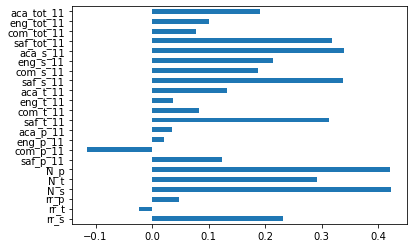

In [56]:
%matplotlib inline
combined.corr()['sat_score'][survey_fields].plot.barh()

## **Exploring safety**

The above bargraph reveals that the columns N_p and N_s have the highest correlation with SAT Scores. The data dictionary reveals that these categories represent the number of students and parents that responded to the survey. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

The next survey columns with the highest positive correlation to Sat Scores is the saf_s_11 column, which represents how students perceive the safety of their schools. This makes sense, if students don't feel safe it is harder for them to learn. I'm going to investigate this relationship further with a scatter plot.

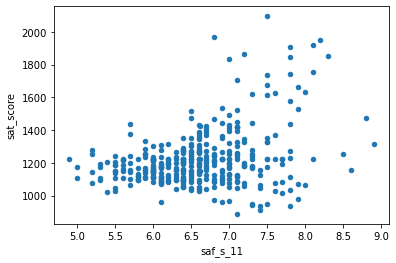

In [62]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

There appears to be a weak correlation between SAT scores and safety. There are a cluster of schools that have extremely high SAT scores and high safety scores. There are also a few outlier schools with safety scores in the middle but low SAT scores. All schools that have an average SAT Score over 1600 have a safety score over 6.5. 

These results show that it is impossible for schools to have high average SAT scores with low safety scores, but it is possible to have high safety scores with low SAT scores.

## Exploring Race and SAT Scores

The goal of this project was to analyze the efficacy of SAT Scores based on demographic factors so now I am going to analyze the relationship between Race and SAT Scores to determine if there are any patterns of inequality.

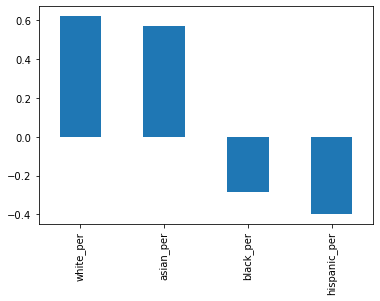

In [30]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][race_fields].plot.bar()

It looks like a higher percentage of White or Asian students at a school correlates positively with sat score, whereas a higher percentage of Black or Hispanic students correlates negatively with sat score. Going to investigate this phenomenon further, focusing on schools with high percentages of Hispanic students

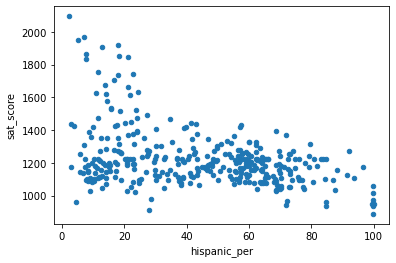

In [31]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

Looking at the scatter plot there are a few outlier schools that have 100% Hispanic students and very low SAT scores. I also noticed that there are a few outlier schools with less than 20% Hispanic students and very high SAT scores.

I would like to analyze this further, so I will filter the data to reveal just these schools in order to discover why this is going on.

In [32]:
combined[combined['hispanic_per'] > 95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Through further investigation I discovered that the schools with 100% Hispanic Students and low SAT Scores are schools specifically for Immigrants and ESL students, these students obviously will struggle with the SAT which requires a strong grasp of the English language. The SAT is definitely not a fair test of their intellectual abilities.

In [33]:
(combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Further investigation reveals that the outliers with extremely low percentages of Hispanic students and high SAT scores are magnet high schools that are very selective and require an entry exam to get into. This explains why the SAT scores are so high at these schools. However it is still unclear why these schools admit a low percentage of Hispanic students, this is something that the NYC government should further investigate. Perhaps there is some subconscious bias occuring during the admissions process.

#### **Exploring Gender and SAT Scores**

The next demographic to consider is Gender and SAT Scores, I will start by creating a bar graph to analyze correlation between the two genders.

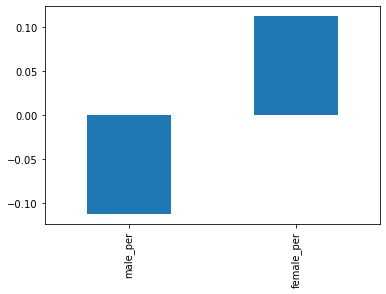

In [34]:
gender_fields = ['male_per', 'female_per']
combined.corr()['sat_score'][gender_fields].plot.bar()

In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. However, both correlations are quite weak.

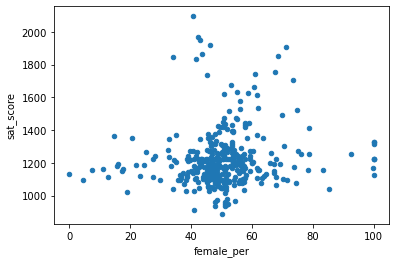

In [35]:
combined.plot.scatter(x='female_per', y='sat_score')

The scatterplot does not show a common pattern of correlation between female percentage and SAT scores. Having a higher percentage of female students does not correlate to higher SAT scores.

#### Exploring AP Scores vs. SAT Scores

In [36]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

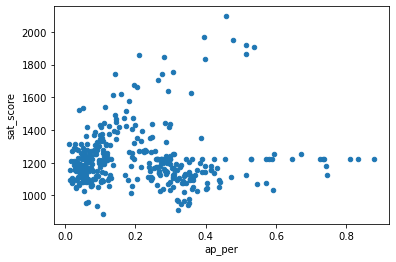

In [37]:
combined.plot.scatter(x='ap_per', y='sat_score')

There looks to be a correlation between Percentage of students who have taken AP exams and SAT Scores but the correlation is quite weak. There are some schools with about a 50% AP percentage and an Average Sat Score over 1800 but there are also schools with about 70-90% AP Percentage and an Average SAT Score of about 1200.

In [38]:
(combined[(combined['ap_per'] > 0.6) & (combined['sat_score'] < 1400)]['SCHOOL NAME'])

6      47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...
31                 MANHATTAN ACADEMY FOR ARTS & LANGUAGE
33             INTERNATIONAL HIGH SCHOOL AT UNION SQUARE
50                        HUMANITIES PREPARATORY ACADEMY
83             HIGH SCHOOL FOR EXCELLENCE AND INNOVATION
111                            BRONX BRIDGES HIGH SCHOOL
208                              FRANCES PERKINS ACADEMY
222               THE BROOKLYN ACADEMY OF GLOBAL FINANCE
321                      HILLSIDE ARTS & LETTERS ACADEMY
335                              CAMBRIA HEIGHTS ACADEMY
Name: SCHOOL NAME, dtype: object

Further investigation into these schools with high AP percentages and low SAT scores reveals that most of these schools are for recent immigrants that promote the taking of AP tests to ensure further academic development. Explaining the low SAT scores combined with the high AP percentages.